# Creating Choropleth Maps with Folium

By Kenneth Burchfiel

Released under the MIT license

*Note: If the Plotly library meets your mapping needs, feel free to skip this section and focus on the mapping code shown in choropleth_maps.ipynb instead. If you're curious about an alternative mapping tool, though, read on!*

*I had originally planned to base PFN's mapping code on Folium; however, I then realized that Plotly had some significant advantages for my own mapping work, so I went ahead and created a Plotly-based mapping notebook also. Both libraries are fantastic tools, and you may very well find that Folium is a better fit for your projects.*

*Also, you can find GitHub pages-hosted copies of two interactive maps shown within this notebook via the following links:*

*Net Migration by County map: https://kburchfiel.github.io/simple_static_site/maps/net_migration_rate_county_2020-2024.html*

*Link to Net Migration by State map: https://kburchfiel.github.io/simple_static_site/maps/net_migration_rate_state_2020-2024.html*

The Static Sites section of Python for Nonprofits will explain how these interactive maps were made available online.

## Introduction

This notebook shows how to use Python's Folium library to generate choropleth maps of county- and state-level net domestic migration rates (which I'll often refer to as 'domestic migration' or 'net migration' to save space). The first part of the code demonstrates how to use Folium's built-in `folium.choropleth()` function; the second part demonstrates how to create a more efficient version of this same choropleth map using a custom function.

**A quick overview of domestic net migration**

Domestic net migration entails movements from one part of a country to another. For instance, if someone moves from Fairfax County, VA to Harris County, TX, Fairfax County's net migration totals for the year would decrease by 1 whereas Harris County's would increase by 1. Note that international migration, births, and deaths do *not* factor into net migration totals. By focusing only on movements within the US, this data offers an intriguing look into which parts of a country are attracting pre-existing residents--and which are failing to attract (or retain) them.

Let's say that NVCU's seniors want to know which parts of the country are particularly popular areas to which to relocate. In order to help answer this question, you've decided to create county-level net domestic migration maps. (The seniors will need to interpret this analysis with caution: for instance, they might not necessarily want to move to a place whose high net domestic migration rates are driven by retirees. Then again, that might be the *perfect* destination for a college grad who loves playing bridge and pickleball!)

Our analyses within this notebook will use net migration *rates* (i.e. net migration totals divided by population totals) rather than nominal net migration counts because the former measure better reflects individuals' likelihood of moving to or from a given region. For instance, a county with 1 million residents and a positive net migration total of 2,000 would be a less 'hot' destination than a one with 100,000 residents and a net migration total of 1,000. The latter county's total net migration is 50% that of the former's, but its rate (1000 / 100,000, or 1%) is five times that of the larger county's (2,000 / 1,000,000, or 0.2%), thus indicating a greater interest in moving there.

In [1]:
import sys
sys.path.insert(1, '../Appendix')
from helper_funcs import config_notebook, wadi
display_type = config_notebook(display_max_columns=5)

Importing the libraries we'll need for this script:

In [2]:
import time
program_start_time = time.time()
import pandas as pd

import folium
import geopandas
import numpy as np
from IPython.display import Image # Source: StacKOverflow user 'zach' at
# https://stackoverflow.com/a/11855133/13097194

from branca.utilities import color_brewer
# color_brewer source code: 
# https://github.com/python-visualization/branca/blob/main/branca/
# utilities.py

from selenium import webdriver # selenium will be used to generate
# screenshots of our HTML-based maps. I found that selenium didn't work 
# correctly within JupyterLab Desktop right after the library was 
# installed; however, when I restarted my kernel and then restarted 
# JupyterLab Desktop, it ended up working fine. (Restarting JupyterLab 
# Desktop alone would likely have resolved this issue also.)

import time
import os
import branca.colormap as cm
# From https://python-visualization.github.io/folium/latest/
# advanced_guide/colormaps.html#StepColormap
from branca.colormap import StepColormap # From Folium's features.py
# source code: 
# https://github.com/python-visualization/folium/blob/main/
# folium/features.py

## Gathering our net migration data

The 'co-est2024-alldata.csv' file, located within the same folder as this code, contains net migration data for US states and counties during the 2020-2024 time period. I found this data on the Census site's **County Population Totals and Components of Change: 2020-2024** (https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html) page. The dataset is listed under a relatively long title:

*Annual Resident Population Estimates, Estimated Components of Resident Population Change, and Rates of the Components of Resident Population Change for States and Counties: April 1, 2020 to July 1, 2024 (CO-EST2024-ALLDATA)*

Definitions of each column within this file can be found within CO-EST2024-ALLDATA.pdf, which I also downloaded from the aforementioned website to this section's folder. (You can find the download link right above the Excel file link; it's titled 'File Layout.')

You may want to check the Census website to see whether a later version of the file exists. As long as that newer file matches the format of 'co-est2024-alldata.csv', the rest of this code should still work correctly (provided that you update the following cell with the new filename).

In [3]:
df_nm = pd.read_csv(
    'co-est2024-alldata.csv', 
    encoding='latin_1') # nm = 'net migration. 
# This dataset contains other population data as well, but we'll mostly 
# use its net migration totals.
# I needed to add in 'encoding = latin_1' because 
# the default encoding setting produced an error message.

# Moving state and county names over to the left in order to
# make the output easier to interpret:
df_nm.insert(0, 'STNAME', df_nm.pop('STNAME'))
df_nm.insert(1, 'CTNAME', df_nm.pop('CTYNAME'))

df_nm.head()

STNAME          CTNAME  ...  RNETMIG2023  RNETMIG2024
0  Alabama         Alabama  ...     8.424880     8.134207
1  Alabama  Autauga County  ...    10.035616    14.159147
2  Alabama  Baldwin County  ...    30.022929    29.648158
3  Alabama  Barbour County  ...    -0.769761    -8.326191
4  Alabama     Bibb County  ...    -3.418959    16.988312

[5 rows x 83 columns]

### Calculating total net migration across all years within the dataset

As specified within the ALLDATA.pdf file, 'DOMESTICMIG' columns show net domestic migration values. There's a standalone column for each year, and all but one of these columns includes data from July 1 of one year to June 30 of the next year. (The one exception is DOMESTICMIG2020, which uses a shorter range of 2020-04-01 to 2020-06-30).

For our choropleth map, we'll look into net migration across the entire date range in the dataset (e.g. 2020-04-01 to the latest date available). As of April 2025, the Census had provided data up to June 30, 2024, but they should make data for later years available in the future.

Therefore, rather than explicitly specifying the years available within our code, we'll instead add in Python code that determines the first and last years with net migration data. This *should* make it easier to update the code with a later dataset. (I say 'should' because, if the Census Bureau decides to change the column names within this dataset, we'll need to rewrite the code anyway to handle those new columns.)


In [4]:
# Determining all columns with nominal net migration data:
# (These columns all begin with DOMESTICMIG. There are also 
# RDOMESTICMIG columns that show migration rates, but checking
# to see whether the *first* 11 characters contain 'DOMESTICMIG'
# will exclude them. 
nm_cols = [column for column in df_nm.columns 
           if column[0:11] == 'DOMESTICMIG']
nm_cols.sort() # This ensures that the first and last columns in our 
# list will show the earliest and latest years with net migration data,
# respectively.
nm_cols

['DOMESTICMIG2020',
 'DOMESTICMIG2021',
 'DOMESTICMIG2022',
 'DOMESTICMIG2023',
 'DOMESTICMIG2024']

Using our list of net migration columns to identify the earliest and latest years with net migration data:

In [5]:
first_nm_year = nm_cols[0][-4:] # -4: retrieves the final 4 characters
# within the column names (i.e. the year).
last_nm_year = nm_cols[-1][-4:]
first_nm_year, last_nm_year

('2020', '2024')

We can now use our column list and starting/ending years to create a column that sums up all domestic net migration values for all years present in the dataset. In addition, we'll create a column that divides this sum by the population values in the first year of the dataset, thus allowing us to determine total net migration rates.

In [6]:
# Adding all of the net migration values within nm_cols together:
df_nm[f'{first_nm_year}-{last_nm_year} Total Domestic \
Net Migration'] = df_nm[nm_cols].sum(axis=1)

# Creating our domestic migration rate column:
# Saving this column name to a variable will make it easier to incorporate
# into other lines of code that use it.
total_nm_rate_col = f'{first_nm_year}-{last_nm_year} Total Domestic Net \
Migration as % of {first_nm_year} Population'

df_nm[total_nm_rate_col] = (
    100 * df_nm[f'{first_nm_year}-{last_nm_year} \
Total Domestic Net Migration'] /
    df_nm[f'ESTIMATESBASE{first_nm_year}']) # Multiplying by 100 converts
    # the proportions into percentages
# As of 2024-05-24, the starting population selected by this code will be
# ESTIMATEBASE2020, which shows population estimates on 2020-04-01.
# There's also a POPESTIMATE2020 column, but its reference date is 
# 2020-07-01. Since we're incorporating net migration data from 2020-04-01
# to 2020-07-01 into our analysis, the ESTIMATEBASE2020 column is the best
# set of population data to use.

df_nm.head()

STNAME          CTNAME  ...  2020-2024 Total Domestic Net Migration  \
0  Alabama         Alabama  ...                                  119132   
1  Alabama  Autauga County  ...                                    2052   
2  Alabama  Baldwin County  ...                                   28757   
3  Alabama  Barbour County  ...                                    -539   
4  Alabama     Bibb County  ...                                     148   

   2020-2024 Total Domestic Net Migration as % of 2020 Population  
0                                           2.370612               
1                                           3.489796               
2                                          12.407720               
3                                          -2.136684               
4                                           0.664154               

[5 rows x 85 columns]

This table contains both county-specific and statewide data. Rows with COUNTY values of 0 represent statewide totals; therefore, we can create county- and state-level versions of this dataset by selecting rows that have non-zero and zero COUNTY values, respectively.

(We could also have used SUMLEV column values (50 for counties and 40 for states) as a basis for this split.)

In [7]:
df_nm_county = df_nm.query("COUNTY != 0").copy()
df_nm_county.head()

STNAME          CTNAME  ...  2020-2024 Total Domestic Net Migration  \
1  Alabama  Autauga County  ...                                    2052   
2  Alabama  Baldwin County  ...                                   28757   
3  Alabama  Barbour County  ...                                    -539   
4  Alabama     Bibb County  ...                                     148   
5  Alabama   Blount County  ...                                    1519   

   2020-2024 Total Domestic Net Migration as % of 2020 Population  
1                                           3.489796               
2                                          12.407720               
3                                          -2.136684               
4                                           0.664154               
5                                           2.568916               

[5 rows x 85 columns]

In [8]:
df_nm_state = df_nm.query("COUNTY == 0").copy()
df_nm_state.head()

STNAME      CTNAME  ...  2020-2024 Total Domestic Net Migration  \
0       Alabama     Alabama  ...                                  119132   
68       Alaska      Alaska  ...                                  -19564   
99      Arizona     Arizona  ...                                  252654   
115    Arkansas    Arkansas  ...                                   68640   
191  California  California  ...                                -1465116   

     2020-2024 Total Domestic Net Migration as % of 2020 Population  
0                                             2.370612               
68                                           -2.667594               
99                                            3.529619               
115                                           2.279223               
191                                          -3.703934               

[5 rows x 85 columns]

### Adding percentile data to each dataset

In order to more easily compare net migration rates, we'll now create a column that calculates the percentile corresponding to each rate.

(Applying this code to each dataset separately prevents state values from influencing county percentiles and vice versa.)

In [9]:
percentile_col = f'{first_nm_year}-{last_nm_year} \
Domestic Net Migration Percentile'
percentile_col

for df in [df_nm_state, df_nm_county]: # Using a for loop allows us to 
    # apply the same code to our state and county DataFrames.
    df[percentile_col] = 100 * df[total_nm_rate_col].rank(pct=True)
    # See https://pandas.pydata.org/pandas-docs/stable/reference/api/
    # pandas.DataFrame.rank.html

df_nm_county.head()

STNAME          CTNAME  ...  \
1  Alabama  Autauga County  ...   
2  Alabama  Baldwin County  ...   
3  Alabama  Barbour County  ...   
4  Alabama     Bibb County  ...   
5  Alabama   Blount County  ...   

   2020-2024 Total Domestic Net Migration as % of 2020 Population  \
1                                           3.489796                
2                                          12.407720                
3                                          -2.136684                
4                                           0.664154                
5                                           2.568916                

   2020-2024 Domestic Net Migration Percentile  
1                                    73.282443  
2                                    97.519084  
3                                    16.634860  
4                                    46.978372  
5                                    66.221374  

[5 rows x 86 columns]

Let's now take a look at the states with the highest and lowest net migration rates in our dataset.

Highest rates:

In [10]:
df_nm_state.sort_values(
    percentile_col, ascending=False).head()

STNAME          CTNAME  ...  \
565            Idaho           Idaho  ...   
2358  South Carolina  South Carolina  ...   
1626         Montana         Montana  ...   
325         Delaware        Delaware  ...   
331          Florida         Florida  ...   

      2020-2024 Total Domestic Net Migration as % of 2020 Population  \
565                                            6.543819                
2358                                           6.153527                
1626                                           4.934072                
325                                            4.682738                
331                                            4.051974                

      2020-2024 Domestic Net Migration Percentile  
565                                    100.000000  
2358                                    98.039216  
1626                                    96.078431  
325                                     94.117647  
331                                     92.156863  

[5 rows x 86 columns]

Lowest rates:

*Note that, while the percentile for the highest state is 100, the lowest state's percentile is ~1.96 (100 / 51). I believe this is because Pandas calculated each entry's percentile as the percentage of entries that are *equal to* or lower than all entries within the dataset. Therefore, since the lowest entry's percentile is at least equal to itself, its percentile won't be 0. This isn't the only way to define percentiles, but it works well enough for our purposes.*

In [11]:
df_nm_state.sort_values(percentile_col, ascending=True).head()

STNAME                CTNAME  ...  \
1862              New York              New York  ...   
329   District of Columbia  District of Columbia  ...   
191             California            California  ...   
559                 Hawaii                Hawaii  ...   
610               Illinois              Illinois  ...   

      2020-2024 Total Domestic Net Migration as % of 2020 Population  \
1862                                          -4.782320                
329                                           -4.253530                
191                                           -3.703934                
559                                           -3.487643                
610                                           -3.260506                

      2020-2024 Domestic Net Migration Percentile  
1862                                     1.960784  
329                                      3.921569  
191                                      5.882353  
559                                      7.843137  
610                                      9.803922  

[5 rows x 86 columns]

We'll now perform the same analysis for counties. However, in order to prevent unusual migration patterns within smaller counties from skewing our results, we'll limit our results to counties that had at least 100,000 residents in 2020.

In [12]:
print(f"{len(df_nm_county.query(\
    'POPESTIMATE2020 >= 100000'))} counties out of {len(df_nm_county)} \
had over 100,000 residents in 2020.")

605 counties out of 3144 had over 100,000 residents in 2020.


In [13]:
df_nm_county.query("POPESTIMATE2020 >= 100000").sort_values(
    percentile_col, ascending=False).head()

STNAME            CTNAME  ...  \
2697           Texas    Kaufman County  ...   
391          Florida     Sumter County  ...   
1935  North Carolina  Brunswick County  ...   
2614           Texas      Comal County  ...   
2767           Texas   Rockwall County  ...   

      2020-2024 Total Domestic Net Migration as % of 2020 Population  \
2697                                          31.722975                
391                                           25.347391                
1935                                          24.743030                
2614                                          24.380365                
2767                                          24.278855                

      2020-2024 Domestic Net Migration Percentile  
2697                                   100.000000  
391                                     99.968193  
1935                                    99.904580  
2614                                    99.872774  
2767                                    99.840967  

[5 rows x 86 columns]

In [14]:
df_nm_county.query("POPESTIMATE2020 >= 100000").sort_values(
    percentile_col, ascending=True).head()

STNAME                CTNAME  ...  \
1865    New York          Bronx County  ...   
1886    New York          Kings County  ...   
229   California  San Francisco County  ...   
1903    New York         Queens County  ...   
1625    Missouri        St. Louis city  ...   

      2020-2024 Total Domestic Net Migration as % of 2020 Population  \
1865                                         -12.349480                
1886                                          -9.744925                
229                                           -9.608922                
1903                                          -9.416053                
1625                                          -9.335669                

      2020-2024 Domestic Net Migration Percentile  
1865                                     0.445293  
1886                                     0.858779  
229                                      0.922392  
1903                                     1.017812  
1625                                     1.113232  

[5 rows x 86 columns]

## Importing county and state boundaries

(See choropleth_maps.ipynb for more information on this step.)

In [15]:
gdf_counties = geopandas.read_file(
    'shapefiles/cb_2023_us_county_500k/cb_2023_us_county_500k.shp')

gdf_counties['geometry'] = gdf_counties['geometry'].simplify(
    tolerance=0.005)

gdf_counties.insert(0, 'County/State', gdf_counties['NAMELSAD'] 
                    + ', ' + gdf_counties['STUSPS'])
gdf_counties.head()


County/State STATEFP  ...      AWATER  \
0  Baldwin County, AL      01  ...  1132887203   
1  Houston County, AL      01  ...     4795415   
2  Barbour County, AL      01  ...    50523213   
3   Sumter County, AL      01  ...    24634880   
4   Miller County, AR      05  ...    36848741   

                                            geometry  
0  POLYGON ((-88.02858 30.22676, -87.96685 30.235...  
1  POLYGON ((-85.71209 31.19727, -85.69231 31.210...  
2  POLYGON ((-85.74803 31.61918, -85.73117 31.629...  
3  POLYGON ((-88.42145 32.30868, -88.34043 32.991...  
4  POLYGON ((-94.04343 33.55158, -94.00037 33.564...  

[5 rows x 14 columns]

Ensuring that no states have two or more counties with the same name (which would likely cause all sorts of headaches):

In [16]:
gdf_counties['County/State'].duplicated(keep=False).sum()

np.int64(0)

Next, we'll import state-level boundaries:

In [17]:
gdf_states = geopandas.read_file(
    'shapefiles/cb_2023_us_state_500k/cb_2023_us_state_500k.shp')
gdf_states['geometry'] = gdf_states['geometry'].simplify(
    tolerance=0.005)
gdf_states.head()

STATEFP   STATENS  ...       AWATER  \
0      35  00897535  ...    726463919   
1      46  01785534  ...   3387709166   
2      06  01779778  ...  20291770234   
3      21  01779786  ...   2384223544   
4      01  01779775  ...   4582326383   

                                            geometry  
0  POLYGON ((-109.05004 31.3325, -109.04522 36.99...  
1  POLYGON ((-104.05788 44.9976, -104.03969 44.99...  
2  MULTIPOLYGON (((-118.60442 33.47855, -118.5386...  
3  MULTIPOLYGON (((-89.41728 36.49901, -89.37637 ...  
4  MULTIPOLYGON (((-88.05338 30.50699, -88.03867 ...  

[5 rows x 10 columns]

### Merging shape and demographic data tables together

Creating a table that stores both demographic and state data often makes graphing tasks easier. Therefore, we'll now merge `gdf_counties` and `df_nm_county` together using their state and county ID columns as keys. In order to make this process easier, we'll rename `gdf_counties`' copies of these ID fields and change their values to integers in the following cell.

In [18]:
# Renaming the ID fields within gdf_counties so that they match the 
# names of their corresponding fields within df_nm_county:
gdf_counties.rename(
    columns = {'STATEFP':'STATE', 
    'COUNTYFP':'COUNTY'}, inplace=True)
# df_nm_county's ID fields are stored as integers, so in order to
# prevent the merge from failing to match integer- and string-formatted 
# numbers we'll convert these to integers as well: 

# (The fact that the IDs have leading 0s is a dead giveaway 
# that they're currently
# stored as strings, though you could also check the output of 
# gdf_counties.dtypes to confirm this.)
for column in ['STATE', 'COUNTY']:
    gdf_counties[column] = gdf_counties[column].astype('int')  
    
gdf_counties.head()

County/State  STATE  ...      AWATER  \
0  Baldwin County, AL      1  ...  1132887203   
1  Houston County, AL      1  ...     4795415   
2  Barbour County, AL      1  ...    50523213   
3   Sumter County, AL      1  ...    24634880   
4   Miller County, AR      5  ...    36848741   

                                            geometry  
0  POLYGON ((-88.02858 30.22676, -87.96685 30.235...  
1  POLYGON ((-85.71209 31.19727, -85.69231 31.210...  
2  POLYGON ((-85.74803 31.61918, -85.73117 31.629...  
3  POLYGON ((-88.42145 32.30868, -88.34043 32.991...  
4  POLYGON ((-94.04343 33.55158, -94.00037 33.564...  

[5 rows x 14 columns]

We're now ready to merge our countyllevel boundary and net migration data together:

In [19]:
gdf_counties_and_stats = gdf_counties.merge(
    df_nm_county, 
    on=['STATE', 'COUNTY'])

gdf_counties_and_stats.head()

County/State  STATE  ...  \
0  Baldwin County, AL      1  ...   
1  Houston County, AL      1  ...   
2  Barbour County, AL      1  ...   
3   Sumter County, AL      1  ...   
4   Miller County, AR      5  ...   

   2020-2024 Total Domestic Net Migration as % of 2020 Population  \
0                                          12.407720                
1                                           1.929803                
2                                          -2.136684                
3                                          -4.601799                
4                                           0.363884                

  2020-2024 Domestic Net Migration Percentile  
0                                   97.519084  
1                                   61.195929  
2                                   16.634860  
3                                    6.743003  
4                                   43.097964  

[5 rows x 98 columns]

Performing the same merge process for our state-level boundary and net migration DataFrames:

In [20]:
# I'd like to use 'State' as the field name for state names,
# so I'll rename this field within both gdf_states and df_nm_state.
# I'll also rename a pre-existing 'STATE' column within df_nm_state
# so that it won't get confused with the new 'State' field.
gdf_states.rename(columns = {'NAME':'State'}, inplace = True)
df_nm_state.rename(columns = {'STNAME':'State', 
                              'STATE':'State_Code'}, inplace = True)


In [21]:
gdf_states_and_stats = gdf_states.merge(
    df_nm_state, on='State')
gdf_states_and_stats.head()

STATEFP   STATENS  ...  \
0      35  00897535  ...   
1      46  01785534  ...   
2      06  01779778  ...   
3      21  01779786  ...   
4      01  01779775  ...   

  2020-2024 Total Domestic Net Migration as % of 2020 Population  \
0                                          -0.377039               
1                                           2.409981               
2                                          -3.703934               
3                                           0.638683               
4                                           2.370612               

  2020-2024 Domestic Net Migration Percentile  
0                                   41.176471  
1                                   78.431373  
2                                    5.882353  
3                                   58.823529  
4                                   76.470588  

[5 rows x 95 columns]

## Creating a choropleth map with interactive tooltips

We can now create a choropleth map that shows net migration data by county. However, if we feed our entire `gdf_counties_and_stats` DataFrame into the mapping code, the resulting HTML file will be much larger than necessary, as it will include a number of columns that aren't actually necessary in creating our map. Therefore, we'll use a condensed version of `gdf_counties_and_stats` as a basis for this map instead.

In [22]:
# Storing columns that we'll need to retain within
# our condensed state- and county-level DataFrames as variables:
shape_col = 'geometry'
county_boundary_name_col = 'County/State'
state_boundary_name_col = 'State'
data_col = total_nm_rate_col

gdf_counties_and_stats_condensed = gdf_counties_and_stats[
[shape_col, county_boundary_name_col, data_col, percentile_col]].copy()

gdf_counties_and_stats_condensed.head()

geometry        County/State  \
0  POLYGON ((-88.02858 30.22676, -87.96685 30.235...  Baldwin County, AL   
1  POLYGON ((-85.71209 31.19727, -85.69231 31.210...  Houston County, AL   
2  POLYGON ((-85.74803 31.61918, -85.73117 31.629...  Barbour County, AL   
3  POLYGON ((-88.42145 32.30868, -88.34043 32.991...   Sumter County, AL   
4  POLYGON ((-94.04343 33.55158, -94.00037 33.564...   Miller County, AR   

   2020-2024 Total Domestic Net Migration as % of 2020 Population  \
0                                          12.407720                
1                                           1.929803                
2                                          -2.136684                
3                                          -4.601799                
4                                           0.363884                

   2020-2024 Domestic Net Migration Percentile  
0                                    97.519084  
1                                    61.195929  
2                                    16.634860  
3                                     6.743003  
4                                    43.097964

In order to create our choropleth map, we'll need to determine which item to use as the key for creating our data. For our county-level map, we'll want to use the 'County/State' column as the key, since it contains unique county names found in both the demographics and county outlines datasets.

However, if we attempt to pass 'County/State' to the `key_on` argument within our choropleth function, we'll get the following error:

`key_on 'County/State' not found in GeoJSON.`

That may strike you as strange: 'County/State' is definitely one of the columns in our GeoDataFrame. However, note that this code is referring to the *GeoJSON* version of this GeoDataFrame. The firstn 500 characters of this file appear as follows:

In [23]:
gdf_counties_and_stats_condensed.to_json()[0:500]
# to_json() is listed at https://geopandas.org/en/stable/docs/reference/
# api/geopandas.GeoDataFrame.html#geopandas.GeoDataFrame

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"County/State": "Baldwin County, AL", "2020-2024 Total Domestic Net Migration as % of 2020 Population": 12.407719822062676, "2020-2024 Domestic Net Migration Percentile": 97.51908396946564}, "geometry": {"type": "Polygon", "coordinates": [[[-88.02858, 30.226763], [-87.966847, 30.235618], [-87.936041, 30.261469], [-87.893201, 30.239237], [-87.78775, 30.254244], [-87.768003, 30.262455], [-87.747171, 30.287768]'

The 'County/State' column in this output is preceded by 'Feature' and 'properties.' Meanwhile, the choropleth example found in the Folium documentation (https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html) uses 'feature.id' as the key_on value. Here's what the beginning of *that* GeoJson file (available at https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json) looks like:

>{"type":"FeatureCollection","features":[
{"type":"Feature","id":"AL","properties":{"name":"Alabama"},"geometry":{"type":"Polygon","coordinates":[[[-87.359296,35.00118],

Note that 'id' is the column with state data (as it's a state-level choropleth map), and that 'properties' comes *after* this value (whereas, in our GeoJson file, 'properties' comes *before* our county column). Therefore, we can make an educated guess that 'feature.properties.County/State' is the right value to pass to the key_on column, and thankfully this guess is correct!

(Folium's API reference (https://python-visualization.github.io/folium/latest/reference.html) also hints at this solution by listing 'feature.properties.statename' as an example of a key_on value.

In my experience, figuring out what value to use for the `key_on` argument is one of the trickier parts of using Folium's Choropleth feature. If you're having trouble with this step, my advice would be to always look at the GeoJson version of your GeoDataFrame and see what values precede it, then incorporate those values ('feature', 'properties', etc.) into your entry.

### Creating our bin ranges

By default, `folium.Choropleth()` will group regions into 6 colored bins; the ranges from these bins will stretch, in equal segments, from the lowest to the highest value. However, because some counties have very high or low net migration rates, this approach will cause our map to look relatively dull, since most counties will be in one of the middle bins.

Therefore, a better setup will be to base our bin ranges on percentiles, as this will result in a relatively equal number of counties' appearing in each bin. (The bins will no longer be equally sized, but that's not an issue in this case.) We can easily determine these bins' cutoff points using pandas' `quantile()` function:

In [24]:
bin_thresholds = list(gdf_counties_and_stats_condensed[
            total_nm_rate_col].quantile(
    np.linspace(0, 1, 11)))
# See https://pandas.pydata.org/pandas-docs/stable/reference/api/
# pandas.DataFrame.quantile.html
# and https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
bin_thresholds

[-27.225850807837745,
 -3.4013516546785283,
 -1.7437151273033404,
 -0.6659052943888464,
 0.11248213244181439,
 0.8985046040638296,
 1.8161218075640675,
 3.0710299250141335,
 4.698758779840584,
 7.261236045002715,
 31.72297529759857]

(A simpler, but less flexible means of accounting for outliers in our dataset would be to set `use_jenks` within `px.Choropleth()` to True. For more details on this argmuent, see https://python-visualization.github.io/folium/latest/reference.html#folium.features.Choropleth .

We can now finally create our choropleth map: (A static copy of this map will be displayed shortly.)

In [25]:
# The following code is based on: 
# https://python-visualization.github.io/folium/latest/user_guide/
# geojson/choropleth.html
# Note: the 'RdYlGn' (red-yellow-green) fill color 
# argument derives from:
# https://colorbrewer2.org/#type=diverging&scheme=RdYlGn&n=3 ,
# a helpful interactive site referenced within the Folium API reference
# (https://python-visualization.github.io/folium/latest/
# reference.html#module-folium.features).
# This color palette isn't listed as one of the available palettes 
# within the choropleth documentation, but it still works fine.


m = folium.Map([38, -95], zoom_start=6, zoom_control = False)

# Disabling the Zoom control will make our screenshot of this map
# a bit cleaner.

folium.Choropleth(
    geo_data=gdf_counties_and_stats_condensed,
    data=gdf_counties_and_stats_condensed,
    bins=bin_thresholds,
    zoom_control=False,
    columns=[county_boundary_name_col, total_nm_rate_col],
    key_on=f'feature.properties.{county_boundary_name_col}',
    fill_color='RdYlGn',
    fillOpacity=0.75
).add_to(m)


m.save('maps/basic_choropleth.html') # Useful for file size comparisons;
# an updated copy of this map that also contains tooltips will be shown
# shortly.

### Adding in tooltips

We have a choropleth map in place, but it's missing something very important: tooltips that will display both the name of a county and its net migration data when the user hovers over it. These tooltips aren't present in the choropleth code by default, but [Folium's documentation](https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson_popup_and_tooltip.html) demonstrates how to easily add them in.

In [26]:
# In the following code, 'fields' lists the values that we wish
# to display within our tooltip, and 'aliases' lists the titles for
# those values.

tooltip = folium.GeoJsonTooltip(
    fields=[county_boundary_name_col, total_nm_rate_col, 
            percentile_col],
    aliases=["County:", 
             f"{first_nm_year}-{last_nm_year} Net Migration \
as % of {first_nm_year} Population:", 'Percentile'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #FFFFFF;
        border: 1px;
        border-radius: 1px;
        box-shadow: 1px;
    """,
    max_width=800
)
# Based on:
# https://python-visualization.github.io/folium/latest/user_guide/
# geojson/geojson_popup_and_tooltip.html

# We'll now add these tooltips to our map by linking them
# to an invisible GeoJson object. (The county outlines were
# already present within the map as a result of the choropleth
# mapping code, so there's no need to add them again here.)

g = folium.GeoJson(
    gdf_counties_and_stats_condensed,
    style_function=lambda x: {
        "fillOpacity": 0,
        "weight":0,
    },
    tooltip=tooltip
).add_to(m)
# Also based on: 
# https://python-visualization.github.io/folium/latest/user_guide/
# geojson/geojson_popup_and_tooltip.html

# We'll now go ahead and save the map:

m.save(
    f'maps/net_migration_rate_county_{first_nm_year}-{last_nm_year}.html')

### Saving a screenshot of this map

The Plotly charting library makes saving static copies of charts simple: we can just call its `write_image()` function. Folium doesn't yet have this sort of functionality, but thankfully, it's still possible to create static copies of its map files. We'll just need to run some Selenium code that opens a web browser; navigates to our map; and then saves a screenshot of the map to a PNG file. The following code shows how to accomplish these steps.

(Note: I have found that Selenium may not work correctly when running a script *right after* installing it. Therefore, if you just installed Selenium and the following cell crashes, try exiting out of JupyterLab Desktop or whatever Jupyter Notebook viewer you're using; reopening it; and then rerunning this script.)

If your error message reads, in part, `NoSuchDriverException: Message: Unable to obtain driver for chrome`, these instructions still apply. Selenium *should* be able to obtain the driver on its own--but you may just need to close and reopen your notebook before it can do so.

In [27]:
options = webdriver.ChromeOptions()
# Source: 
# https://www.selenium.dev/documentation/webdriver/browsers/chrome/

options.add_argument('--window-size=3000,1688') # I found that this window
# size, along with a starting zoom of 6 within our mapping code,
# created a relatively detailed map of the contiguous 48 US states. 
# If you'd like to create an even more detailed map, consider setting 
# your starting zoom to 7 and your window size to 6000,3375.

options.add_argument('--headless') # This addition 
# (which prevents the Selenium-driven browser from displaying on your 
# computer) was necessary for allowing 4K screenshots to get saved
# as 3840x2160-pixel images. Without this line, the screenshots would 
# get rendered with a resolution of 3814x1868 pixels.
# Source of the above two lines:  
# https://www.selenium.dev/documentation/webdriver/browsers/chrome/
# and
# https://github.com/GoogleChrome/chrome-launcher/blob/main/docs/
# chrome-flags-for-tools.md

# I learned about the necessity of using headless mode *somewhere* on 
# StackOverflow. Many answers to this question regarding generating 
# screenshots reference it as an important step, for instance:
# https://stackoverflow.com/questions/41721734/take-screenshot-of-
# full-page-with-selenium-python-with-chromedriver/57338909

# Launching our Selenium driver:
driver = webdriver.Chrome(options=options) 
# Source: https://www.selenium.dev/documentation/webdriver/
# browsers/chrome/

# Navigating to our map:
# Note: I needed to precede the local path with 'file://' as 
# noted by GitHub user lukeis here: 
# https://github.com/seleniumhq/selenium-google-code-issue-archive\
# /issues/3997#issuecomment-192014472
driver.get(
    'file://'+os.getcwd() + '/maps/' + f'net_migration_rate_county_\
{first_nm_year}-{last_nm_year}.html')
# Source: https://www.selenium.dev/documentation/
# Adding in os.getcwd() + '/' converts our relative path 
# (which, by itself wouldn't be compatible with Selenium)
# into an absolute path. (Note that '/' still works on Windows, at least
# in my experience.) 

time.sleep(3) # Helps ensure that the browser has enough time to download
# map contents from the tile provider

# Taking our screenshot and then saving it as a PNG image:

driver.get_screenshot_as_file(
f'map_screenshots/net_migration_rate_county_\
{first_nm_year}-{last_nm_year}.png')
# Source: 
# https://selenium-python.readthedocs.io/api.html#selenium.webdriver.
#remote.webdriver.WebDriver.get_screenshot_as_file

# Exiting out of our webdriver:
driver.quit()
# Source: https://www.selenium.dev/documentation/

Now that we've saved our screenshot, we can finally take a look at our map:

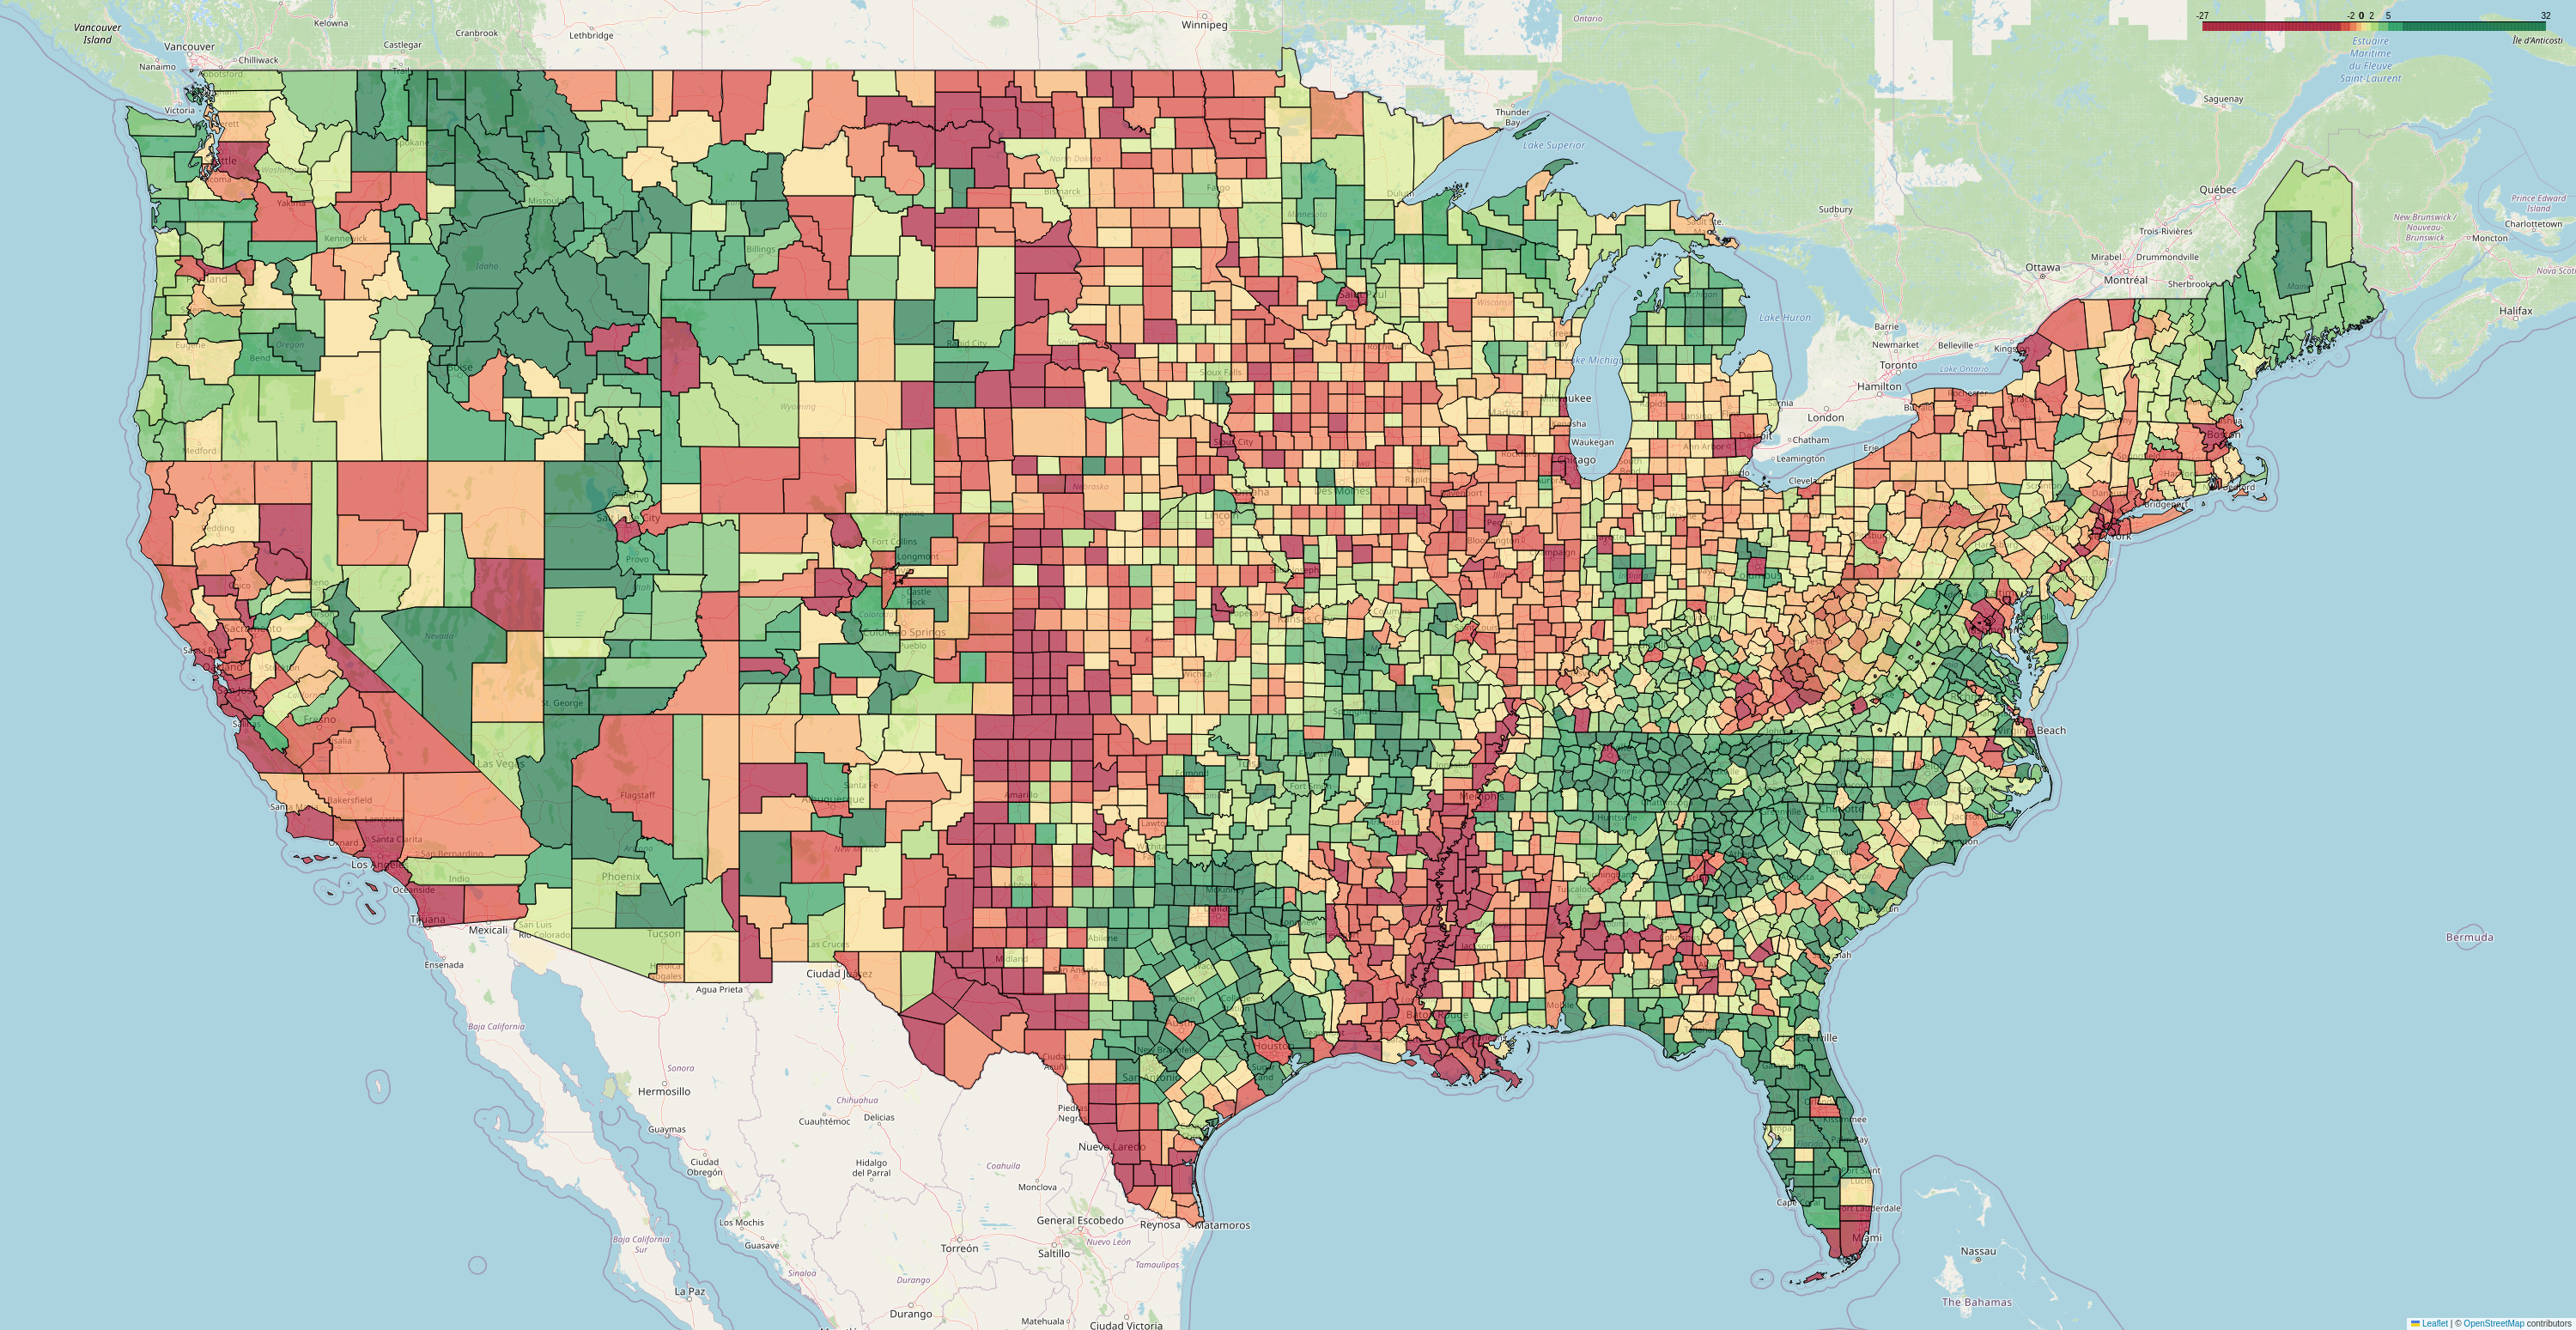

In [28]:
wadi(m, f'map_screenshots/net_migration_rate_county_\
{first_nm_year}-{last_nm_year}',
     generate_image=False, display_type=display_type)

Note that the colorbar in the top right is rather small. Although it's possible to enlarge this colorbar, I found the process for doing so to be much more complex in Folium than in Plotly.

### The drawback of the choropleth mapping approach shown above

We now have a choropleth map that shows additional information when the user hovers over a given county. That's great! However, although this means of creating our map is relatively simple (and a good introduction to the use of Folium), it does have one significant flaw: it results in unnecessarily large file sizes.

On my computer, the first version of the map (with no tooltips) was around 6.5 MB in size. Once tooltips were added in, this map doubled in size to 13.0 MB. This increase occurred because we added many items to the underlying HTML file twice, including our county boundaries. 

Now, 13 MB isn't that large of a file, but the larger your maps get, the harder (and potentially more expensive) it is to host them online, and the longer they'll take to load. If you're working with zip code-level data, this doubling in size could become a major issue.

Therefore, I'll now demonstrate a method that bypasses Folium's Choropleth map class and instead allows the same set of borders to be used for tooltips and region colors. The map created with this method will be only 6.5 MB in size, yet it will still have the same interactive tooltips as the map we just created.

## Creating a more efficient version of this map

In order to create a choropleth map without relying on Folium's Choropleth class, we'll need to develop a colormap that we can use to assign different colors to different net migration values. I borrowed from the `folium.Choropleth()` source code in order to determine how best to accomplish this.

In [29]:
color_range = color_brewer('RdYlBu', n = 10)
# Based on folium.Choropleth() definition within
# https://github.com/python-visualization/folium/blob/main/folium/
# features.py

# Note: to reverse one of these color schemes, add '_r' 
# to the end of the first argument (e.g. 'RdYlBu_r'). 
# Source: https://github.com/python-visualization/branca/blob/
# main/branca/utilities.py

# The following output shows the 10 colors (in hexadecimal format) 
# that comprise this color range:
color_range

['#a50026',
 '#d73027',
 '#f46d43',
 '#fdae61',
 '#fee090',
 '#e0f3f8',
 '#abd9e9',
 '#74add1',
 '#4575b4',
 '#313695']

### Using this color range to initialize our colormap

Note that passing our quantile-based bins to the index argument allows the colormap to reference those bins when determining which colors to assign to which values.

In [30]:
stepped_cm = StepColormap(
    colors = color_range, 
    vmin = bin_thresholds[0], vmax = bin_thresholds[-1],
    index = bin_thresholds)
# Based on the self.color_scale initialization within 
# Folium's Choropleth() source code (available at
# https://github.com/python-visualization/folium/blob/main/folium/
# features.py)

stepped_cm

We can apply this colormap to determine the colors corresponding to a given net migration value as follows:

In [31]:
stepped_cm(gdf_counties_and_stats_condensed.iloc[0][total_nm_rate_col])

'#313695ff'

### Creating our tooltips and choropleth map simultaneously via folium.GeoJson

In [32]:
# Much of this cell is based on the sample code found at 
# https://python-visualization.github.io/folium/latest/user_guide/
# geojson/geojson_popup_and_tooltip.html# 
# and https://python-visualization.github.io/folium/latest/
# user_guide/geojson/geojson.html .

m = folium.Map([40, -95], zoom_start=5)

tooltip = folium.GeoJsonTooltip(
    fields=[county_boundary_name_col, total_nm_rate_col,
           percentile_col],
    aliases=["County:", 
             f"{first_nm_year}-{last_nm_year} Net Migration \
as % of {first_nm_year} Population:", 'Percentile'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #FFFFFF;
        border: 1px;
        border-radius: 1px;
        box-shadow: 1px;
    """,
    max_width=800
)

# The following code will both assign colors from our StepColorMap
# to each county *and* add in our tooltips. This approach allows both
# our colors and tooltips to reference the same set of county outlines,
# thus making for a more efficient map.

g = folium.GeoJson(
    gdf_counties_and_stats_condensed,
    style_function=lambda x: {
        "fillColor": stepped_cm(
            x["properties"][total_nm_rate_col]),
        "fillOpacity": 0.6,
        "weight":1,
        "color":"black"
    },
    tooltip=tooltip
).add_to(m)
# The Folium.GeoJSON overview at
# https://python-visualization.github.io/folium/latest/user_guide/
# geojson/geojson.html
# contributed to this code as well.
# Note that we need to add ["properties"] in between x and 
# [total_nm_rate_col], likely because gdf_counties_and_stats_condensed
# is being interpreted as a GeoJSON object. I based this off of the
# "if "e" in feature["properties"]["name"].lower()" line within
# the above link.

# Adding our StepColorMap to the output as well:
stepped_cm.add_to(m)

m.save(
    f'maps/net_migration_rate_county_{first_nm_year}-{last_nm_year}.html')

# A view of this map will be shown later within this notebook.

### Converting this second mapping approach into a function

In order to make this code easier to apply to other datasets, I converted it into a function (`cptt()`) by replacing hardcoded values with variables. (This is often how I create functions: I start with a working example that uses built-in values, then make that example more flexible by substituting variable names for those values.) 

`cptt()` can be found within 'folium_choropleth_map_functions.py'; I placed it there so that it could be more easily called by different notebooks.

I also added code to this function that allows a selected column's data to be displayed directly atop each boundary by default; this eliminates the need to first hover over a state to view its corresponding metric (which isn't possible for static maps anyway). This code works much better for state-level data (which we'll graph later) than county-level data, since the latter shapes are too small to accommodate these labels at a nationwide zoom level.

### Calling this function separately for HTML and PNG maps

I've found that, if I try to use the same zoom level for both an HTML file and a screenshot, one of the maps will end up showing too much or too little zoom. Therefore, it can be useful to call `cptt()` twice--once to create a PNG version of a map, and again to create an HTML version. `create_map_and_screenshot()`, also available within folium_choropleth_map_functions.py, makes it easier to perform these two function calls. 

Ideally, we could eliminate the need to call `cptt()` twice by updating the zoom level of the map within our code; this would allow us to save an HTML copy of the map for interactive viewing, then update its zoom to better accommodate a screenshot. Even better, we could try using Selenium to adjust the zoom, which would eliminate the need to create two separate HTML maps.

I tried out some code for both of these options, but neither worked successfully. Therefore, I'm sticking for now to the slower, yet reliable approach shown within `create_map_and_screenshot()`.

In [33]:
# Importing the two functions described above:
from folium_choropleth_map_functions import cptt, create_map_and_screenshot

### Applying these functions to create HTML and PNG versions of our net migration by county map with optimized zoom levels

Generating screenshot.
Removed HTML copy of map.


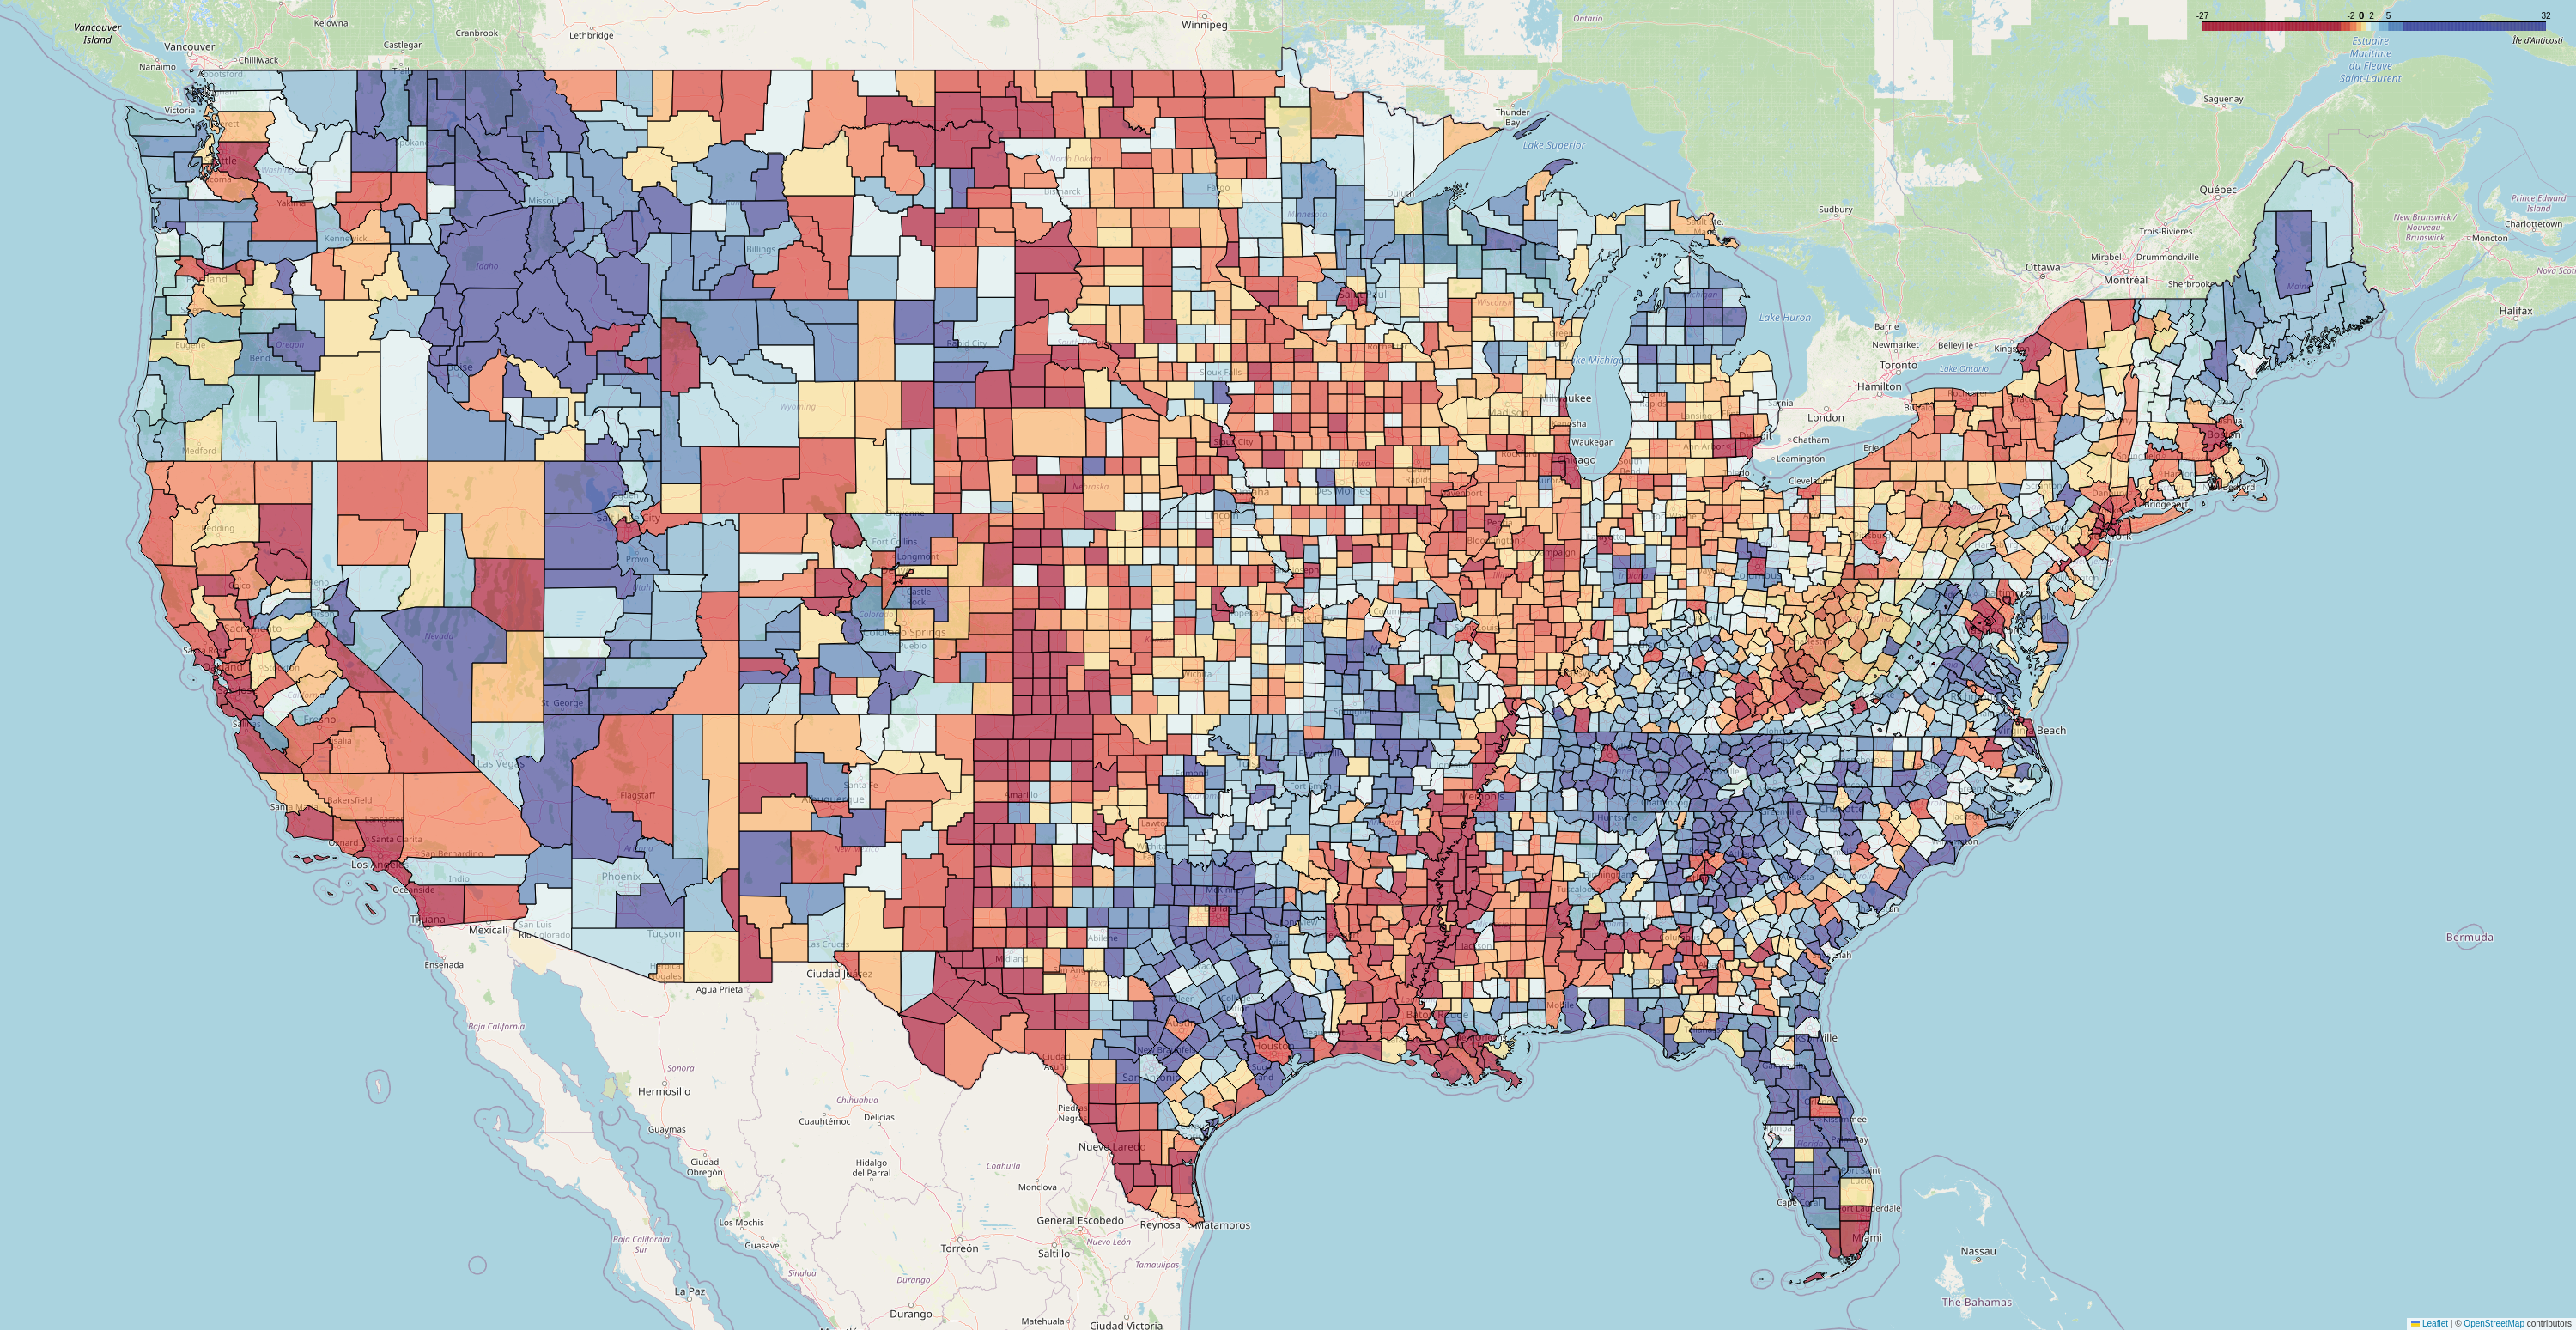

In [34]:
# Defining data_col_alias outside of the function call to make the latter
# a bit more readable:

data_col_alias = f"{first_nm_year}-{last_nm_year} Net Migration \
as % of {first_nm_year} Population:"

map_filename = f'net_migration_rate_county_{first_nm_year}-{last_nm_year}'

# Because cptt() automatically condenses the GeoDataFrame to include
# only those columns necessary for creating the map and tooltips,
# we can pass the original gdf_counties_and_stats GeoDataFrame as our 
# gdf argument.

m = create_map_and_screenshot(
    starting_lat=38, starting_lon=-95, 
    html_zoom_start=5,
    screenshot_zoom_start=6,
    gdf=gdf_counties_and_stats, 
    data_col=total_nm_rate_col, 
    boundary_name_col=county_boundary_name_col,
    data_col_alias=data_col_alias, boundary_name_alias='County:',
    tooltip_variable_list=[percentile_col], 
         tooltip_alias_list=['Percentile:'],
    bin_type='percentile', bin_count=10, color_scheme='RdYlBu',
        map_filename=map_filename,
        html_map_folder=os.getcwd()+'/maps',
        png_map_folder=os.getcwd()+'/map_screenshots')
# Note the use of os.getcwd() to convert the relative paths to the 'maps'
# and 'map_screenshots' folders into full paths.

wadi(m, f'map_screenshots/net_migration_rate_county_\
{first_nm_year}-{last_nm_year}',
     generate_image=False, display_type=display_type)

### Calling `create_map_and_screenshot()` again to create state-level net migration maps in HTML and PNG form

For demonstration purposes, I set the 'tiles' argument to None in order to create a clean and simple map without any underlying tile data. Since there won't be anything to show under the choropleth boundaries, we can set choropleth_opacity to 1, resulting in a more vivid map.

(Note that one drawback of this tileless map, relative to the Plotly option found within `choropleth_maps.ipnyb()`, is that Alaska and Hawaii aren't added to the southwest corner of the map.)

I also chose to add net migration rates as boundary labels. In order to make the labels a bit easier to read, I switched the color scheme from RdYlBu to RdYlGn.

Generating screenshot.
Removed HTML copy of map.


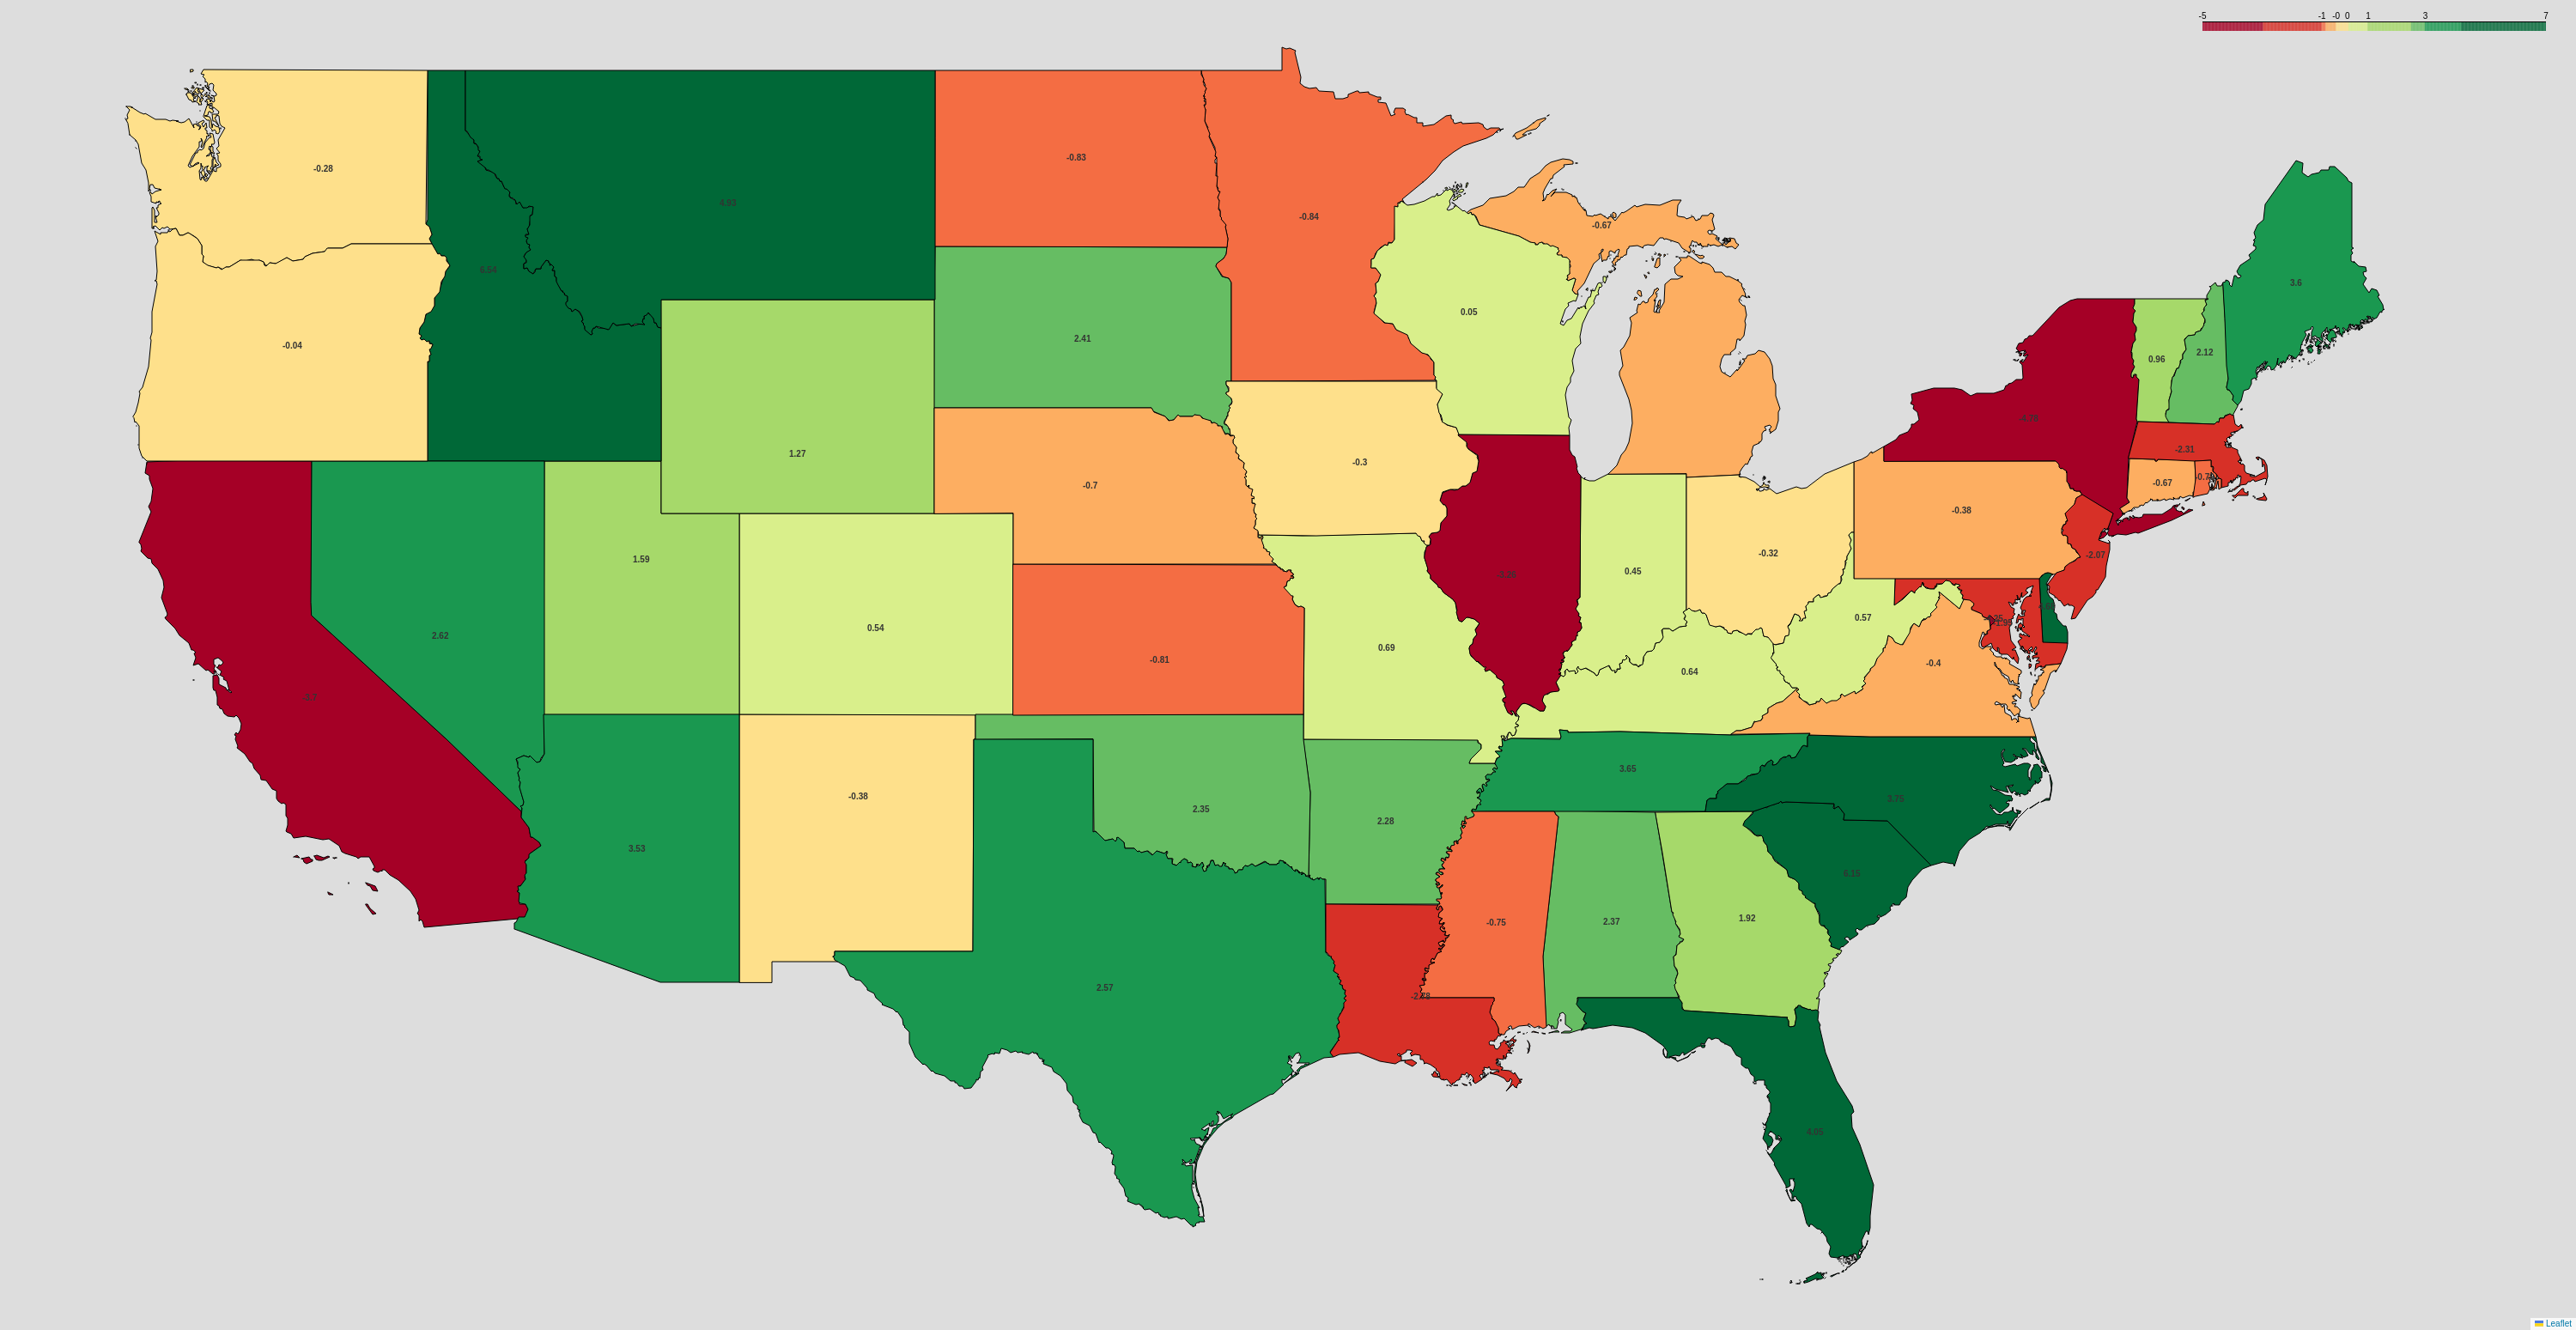

In [35]:
# We'll use the same data_col_alias that we created for our county-level
# map

map_filename = f'net_migration_rate_state_{first_nm_year}-{last_nm_year}'

m = create_map_and_screenshot(
    starting_lat = 38, starting_lon = -95, 
    html_zoom_start = 5,
    screenshot_zoom_start= 6, 
    gdf = gdf_states_and_stats, 
    data_col = total_nm_rate_col, 
    boundary_name_col = state_boundary_name_col,
    data_col_alias = data_col_alias, boundary_name_alias = 'State:',
    tooltip_variable_list = [percentile_col], 
         tooltip_alias_list = ['Percentile:'],
    bin_type = 'percentile', bin_count = 10, color_scheme = 'RdYlGn',
        map_filename = map_filename, tiles = None,
        choropleth_opacity = 1,
        add_boundary_labels = True, 
        boundary_label_col = total_nm_rate_col,
        round_boundary_labels = True,
        boundary_label_round_val = 2,
        html_map_folder = os.getcwd()+'/maps',
        png_map_folder = os.getcwd()+'/map_screenshots')

wadi(m, f'map_screenshots/net_migration_rate_state_\
{first_nm_year}-{last_nm_year}',
     generate_image = False, display_type = display_type)


The labels in the screenshot, like the colorbar in the top right, are admittedly quite small. Both of these will appear larger within the HTML version of the map.

## Conclusion

That's it for this notebook! I would have liked to keep this section simpler, but building choropleth maps can get a little complex, especially if you wish to bypass `folium.Chorolpeth()`. I hope you'll find both this notebook and the functions shown within 'folium_choropleth_map_functions.py' useful for your own mapping projects. (I do recommend reviewing that file as well so that you'll better understand how the final maps within this notebook were created.)

In [36]:
program_end_time = time.time()
run_time = program_end_time - program_start_time
print(f"Finished running program in {round(run_time, 3)} seconds.")

Finished running program in 21.714 seconds.
